First off install dependencies. This assumes that the notebook is run in the correct virtualenv.

In [ ]:
!pip install pandas numpy seaborn gpy sklearn plotly

## Rename & Repackage Data
The data was in a format I did not prefer so it is renamed and repackaged here. This has to be done in several steps, else there is a memory error.

In [8]:
import pandas as pd
from math import radians, sin, cos

train_path = '../data/train3.pkl'
test_path = '../data/test3.pkl'

def equirectangular_projection(data):
    phi = data.lat.apply(radians)
    lamb = data.lon.apply(radians)
    lamb0 = lamb.mean()
    phi0 = phi.mean()
    r = 6378000  # earth radius in m
    x = r*(phi-phi0)
    y = r*(lamb - lamb0)*cos(phi0)
    return x, y

def compute_velocity(row):
    
    r = row.speed
    theta = radians(row.direction)
    row['dx'] = r*cos(radians(theta))
    row['dy'] = r*sin(radians(theta))
    return row

def filter_position_observed_events(data):
    return data[data.event == 'ObservedPositionEvent']

def repackage(from_path, to_path):
    data = pd.read_pickle(from_path)
    
    # Remove unnecessary fields
    del data['vehicle_id']
    del data['line']
    del data['station']
        
    data = filter_position_observed_events(data)
    
    del data['event']
    
    data.timestamp = data.timestamp.apply(pd.to_datetime)
    data = data.rename(columns = {
        'latitude': 'lat',
        'longitude': 'lon',
        'journey_number': 'traj',
        'segment_number': 'seg', 
        'speed': 'speed',
        'event': 'event',
        'timestamp': 'timestamp'
    })
    
    x, y = equirectangular_projection(data)
    data['x'] = x
    data['y'] = y
    
    del data['lat']
    del data['lon']

    data = data.apply(compute_velocity, axis=1)
    
    del data['direction']
    del data['speed']
    
    data.to_pickle(to_path)
    
repackage('../data/203_train.p', train_path)
repackage('../data/203_test.p', test_path)

KeyboardInterrupt: 

In [14]:
#data = pd.read_pickle('../data/train3.pkl')
#data.head()
def mean_timestamp(timestamps):    
    return pd.to_datetime(timestamps.values.astype(np.int64).mean())

X = data.iloc[0].copy()
data.iloc[4].timestamp = 6
X.timestamp = mean_timestamp(data.iloc[:10].timestamp)
compressed_data = data.drop(['timestamp', 'event', 'seg', 'station', 'line', 'traj'], axis=1).apply(np.mean, axis=0)
compressed_data['timestamp'] = mean_timestamp(data.iloc[:10].timestamp)# pd.Timestamp(2017, 1, 1, 12)
#compressed_data.timestamp = mean_timestamp(data.iloc[:10].timestamp)
compressed_data

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2018-02-16 03:48:40
2018-02-16 03:48:42.800000


Unnamed: 0                485.027
vehicle_id                5451.22
lon                       58.4093
lat                       15.5723
direction                  123.11
speed                      5.1206
timestamp     1518752922800000000
dtype: object

## Load training data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from IPython.display import display, clear_output
from model import learn_trajectory_model, plot_function, gamma_prior, FunctionModelPriors, TrajectoryModel, predict
from pandas import DataFrame

np.random.seed(1)
trajs_pickle_path = '../data/train3.pkl'
data = pd.read_pickle(trajs_pickle_path)
n_trajs = list(data.traj.unique())
n_trajs_to_use = 20 # len(n_trajs)
trajs_to_use = frozenset(np.random.choice(n_trajs, size=n_trajs_to_use, replace=False))
trajs = data[data.traj.transform(lambda j: j in trajs_to_use)]
traj_ns = trajs.traj.unique()
def load_seg(traj_n, seg_n):
    return trajs[(trajs.traj == traj_n) & (trajs.seg == seg_n)]

## Learn normalisation functions for each segment
All trajectories must be in the same space, so normalisation is done segement-wise. This will not be Euclidian, so ARD need to be used.

In [2]:
from math import sqrt
seg_dict = dict(tuple(data.groupby('seg')))
def normalisation(seg: DataFrame):
    dx = seg.x.mean()
    dy = seg.y.mean()
    sd  = sqrt(max(seg.x.var(), seg.y.var()))
    def do_normalisation(data):
        data2 = data.copy()
        data2.x = (data.x - dx)/sd
        data2.y = (data.y - dy)/sd
        return data2
    
    return {
        'scale': do_normalisation,
        'sd': sd,
        'dx': dx,
        'dy': dy
    }
seg_norms = {
    seg_n: normalisation(seg_dict[seg_n])
    for seg_n in seg_dict
}

def normaliser_for_seg(seg_n: int):
    return seg_norms[seg_n] 

## Pre processing logic

In [4]:
from numpy import ndarray
import math

def drop_start_dwell(data: DataFrame):
    # https://stackoverflow.com/questions/52907328/pandas-delete-first-n-rows-until-condition-on-columns-is-fulfilled
    return data.loc[((data.dx > 0) & (data.dy > 0)).idxmax():]
    
    
def take_fraction(data, r):
    return data[data.tau <= r]
    #n = int(np.round(r*data.shape[0]))
    #return data.iloc[:n]


def compute_tau(data: DataFrame) -> ndarray:
    return np.linspace(0, 1, data.shape[0])


def compute_time_left(data: DataFrame) -> DataFrame:
    sorted_data = data.sort_values('timestamp')
    arrival_time = sorted_data.iloc[-1].timestamp
    sorted_data['time_left'] = [
        (arrival_time - t).seconds
        for t in sorted_data.timestamp
    ]
    return sorted_data
    
    
def compute_velocity_from_pos(data: DataFrame):
    """Assume one data point per second."""
    def velocity(cur, nxt):
        #dt = nxt.timestamp.second - cur.timestamp.second
        dxx = float(nxt.x - cur.x) #/ dt
        dyy = float(nxt.y - cur.y) #/ dt
       # print(nxt.y, cur.y)
        return dxx, dyy #if dt > 0 else None

    dx = []
    dy = []
    for n in range(0, data.shape[0]-1):
        cur = data.iloc[n]
        nxt = data.iloc[n+1]
        dv = velocity(cur, nxt)
        
        # If two observations are sent the same 
        # seconds, everything breaks
        if dv is None:
            nxt2 = data.iloc[n+2]
            dv = velocity(cur, nxt2)
        

        dx.append(dv[0])
        dy.append(dv[1])
            
    dx.append(dx[-1])
    dy.append(dy[-1])
    return dx, dy


def pre_process(data: DataFrame, stop_compress_delta: float, fraction_observed: float = 1) -> DataFrame:
    data = compute_time_left(data)
    
    data = stop_compress(data, stop_compress_delta)
    dx, dy = compute_velocity_from_pos(data)
    data['dx'] = dx
    data['dy'] = dy
    
    data['tau'] = compute_tau(data)
    data = take_fraction(data, fraction_observed) 
    normaliser = normaliser_for_seg(data.iloc[0].seg)
    return normaliser['scale'](data)

## Learn a model

Optimization restart 1/3, f = 172.64086415983192
Optimization restart 2/3, f = 172.64086415908898
Optimization restart 3/3, f = 172.6408641592842
Optimization restart 1/3, f = 116.47438351809826


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.sum.linear.variances


Optimization restart 2/3, f = 116.47437396270314
Optimization restart 3/3, f = 116.4743740885685
Optimization restart 1/3, f = -161.839210288373
Optimization restart 2/3, f = -161.8392102972992
Optimization restart 3/3, f = -161.83921029882777


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.sum.linear.variances


Optimization restart 1/3, f = -179.59688088909377
Optimization restart 2/3, f = -179.59688088909004
Optimization restart 3/3, f = -179.5968808890412


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\pandas\core\frame.py:6211: FutureWarning:Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Optimization restart 1/3, f = -3776.591770143821
Optimization restart 2/3, f = -3776.5917701877142
Optimization restart 3/3, f = -3776.591770184593
Optimization restart 1/3, f = 277.50574390124837
Optimization restart 2/3, f = 277.5398139975828
Optimization restart 3/3, f = 277.5057439019785


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


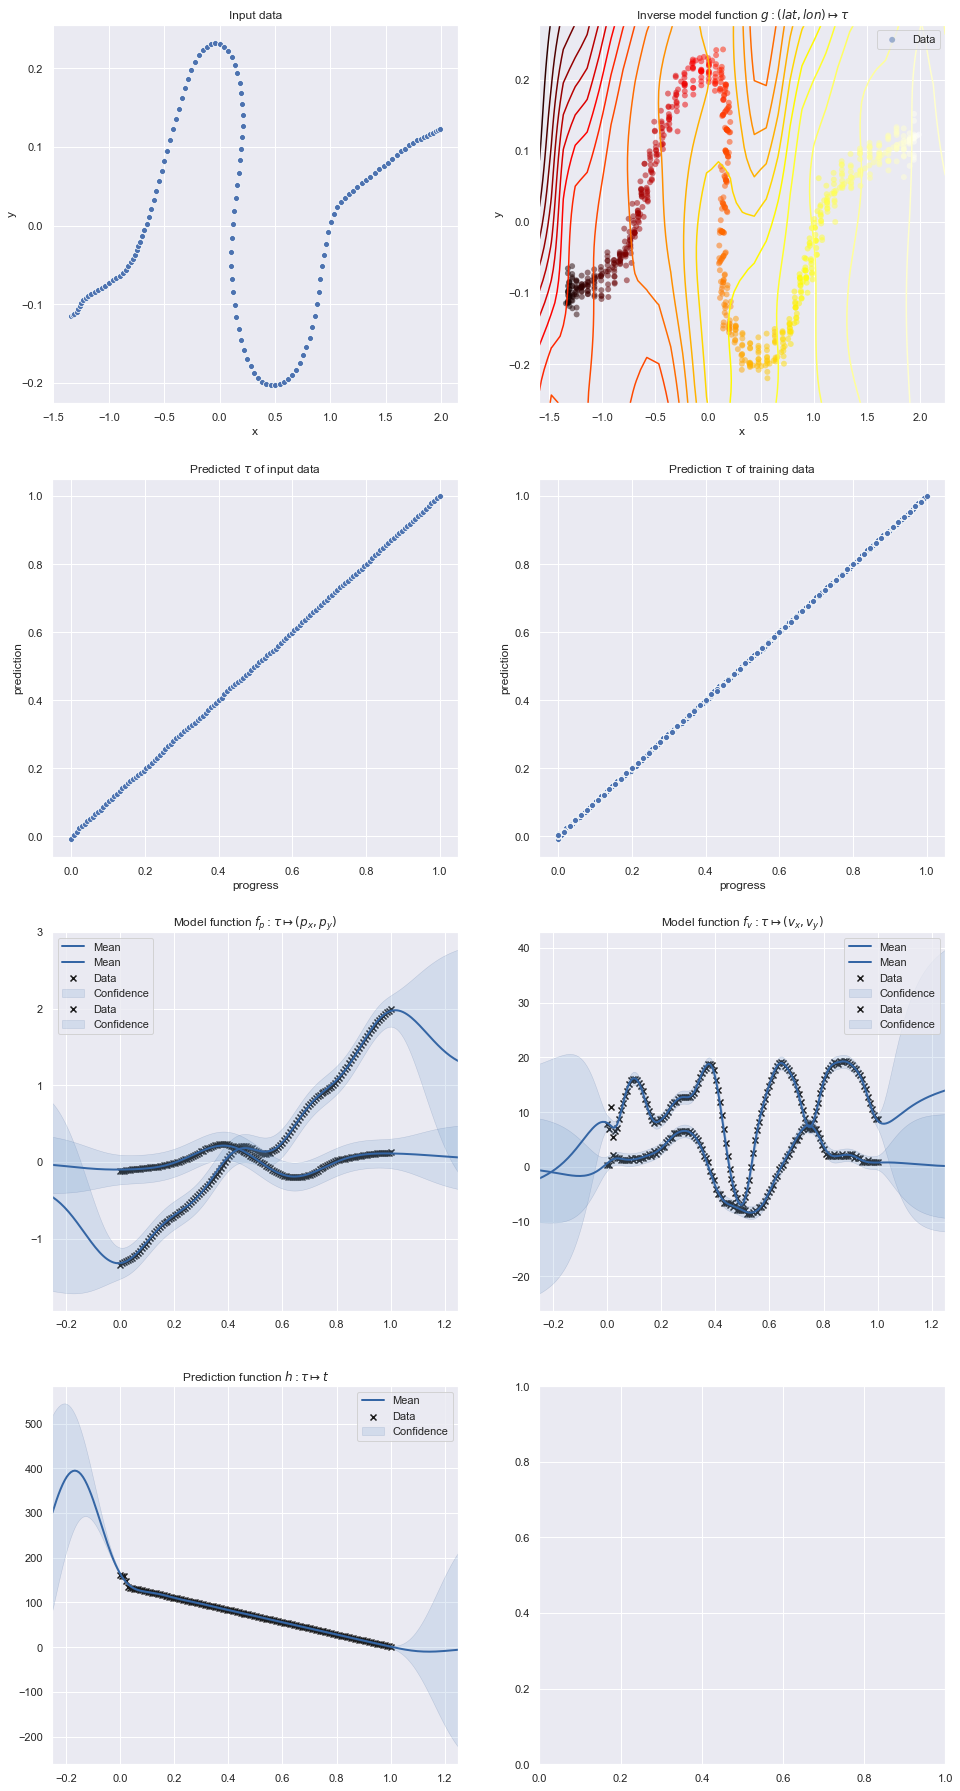

In [7]:
from math import sqrt, cos, sin, radians
from plotting import plot_grid
import seaborn as sns
import GPy
from GPy.models import GPRegression
from typing import List
from model import FunctionModel

%matplotlib inline
sns.set(style="darkgrid")

def learn_function(
    X: ndarray, Y: ndarray, applyPriors,
    f_type: str, route: int, segment: int, kernel=None,
    n_restarts=3
) -> FunctionModel:
    #print(kernel)
    model = GPRegression(
        X, Y, kernel, 
        normalizer=False
    )
    applyPriors(model)    
    #print(model)
    model.optimize_restarts(n_restarts)
    return FunctionModel(
        f_type, model
    )

def create_support_data(
    pos: ndarray,
    tau: ndarray,
    f_p_x, f_p_y, f_v_x, f_v_y, 
    n_samples: int,
    delta: float,
    sigma: float) -> DataFrame:

    def orth_comp(v):
        return np.array([-v[1], v[0]])

    tau_grid = np.linspace(
        np.min(np.min(tau)),
        np.min(np.max(tau)),
        1/delta
    )
    
    tau = tau_grid.reshape(len(tau_grid), 1)
    x, _ = predict(f_p_x, tau)
    y, _ = predict(f_p_y, tau)
    dx, _ = predict(f_v_x, tau)
    dy, _ = predict(f_v_y, tau)
    acc = []
    pos = np.hstack([x, y])
    vel = np.hstack([dx, dy])
    for n in range(len(tau_grid)-1):
        cur_vel = vel[n]
        cur_pos = pos[n]
        nxt_pos = pos[n+1]
        orth_delta = orth_comp(nxt_pos - cur_pos)
        orth_delta = orth_delta / np.linalg.norm(orth_delta)
        
        acc.extend([
            {'x': x[0],
             'y': x[1],
             #'dx': cur_vel[0],
             #'dy': cur_vel[1],
             'tau': tau_grid[n]}
            for x in [
                cur_pos + orth_delta * x
                for x in np.random.normal(0, sigma, n_samples)
            ]
        ])

    return pd.DataFrame(acc)

def learn_model(data: DataFrame, route_n: int, seg_n: int, f_p_codomain, f_v_codomain) -> TrajectoryModel:
    tau = data['tau'].values.reshape(-1, 1)
    
    def apply_f_v_x_priors(m):
        m.kern_lengthscale=gamma_prior(0.04, 0.04),
        m.kern_variance=gamma_prior(75, 5),
        m.likelihood_noise=gamma_prior(0.4, 0.4)
        m.likelihood.variance = 0.3 
        m.likelihood.variance.fix()
        
    def apply_f_v_y_priors(m):
        m.kern_lengthscale=gamma_prior(0.04, 0.04),
        m.kern_variance=gamma_prior(75, 5),
        m.likelihood_noise=gamma_prior(0.4, 0.4)
        m.likelihood.variance = 0.3 
        m.likelihood.variance.fix()
        
    def apply_f_p_x_priors(m):
        m.kern.rbf.lengthscale.set_prior(gamma_prior(0.15, 0.1))
        m.kern.rbf.variance.set_prior(gamma_prior(0.25, 0.1))
        m.kern.linear.variances.set_prior(gamma_prior(0.15, 0.1))
        m.likelihood.variance = f_p_likelihood_noise
        m.likelihood.variance.fix()
        
    def apply_f_p_y_priors(m):
        m.kern.rbf.lengthscale.set_prior(gamma_prior(0.15, 0.1))
        m.kern.rbf.variance.set_prior(gamma_prior(0.25, 0.1))
        m.kern.linear.variances.set_prior(gamma_prior(0.15, 0.1))
        m.likelihood.variance = f_p_likelihood_noise
        m.likelihood.variance.fix()
        
    def apply_g_priors(m):
        return
        m.kern.rbf.lengthscale.set_prior(gamma_prior(0.10, 0.05))
        m.kern.rbf.variance.set_prior(gamma_prior(0.25, 0.1))
        m.kern.linear.variances.set_prior(gamma_prior(0.15, 0.1))
        m.likelihood.variance = f_p_likelihood_noise
        m.likelihood.variance.fix()
             
    def apply_h_priors(m):
        return
          
    f_v_x = learn_function(
        tau, data['dx'].values.reshape(-1, 1),
        apply_f_v_x_priors, 'f_v_x',
        route_n, seg_n, kernel=GPy.kern.Matern52(
            input_dim=1,
            ARD=False
        ) + GPy.kern.Linear(
            input_dim=1,
            ARD=False
        )
    )

    f_v_y = learn_function(
        tau, data['dy'].values.reshape(-1, 1), 
        apply_f_v_y_priors, 'f_v_y', 
        route_n, seg_n, kernel=GPy.kern.Matern52(
            input_dim=1,
            ARD=False
        ) + GPy.kern.Linear(
            input_dim=1,
            ARD=False
        )
    )
    
    normaliser = normaliser_for_seg(seg_n)
    f_p_likelihood_noise = 4 / normaliser['sd']
    
    f_p_x = learn_function(
        tau, data['x'].values.reshape(-1, 1),
        apply_f_p_x_priors, 'f_p_x',
        route_n, seg_n, kernel=GPy.kern.RBF(
            input_dim=1,
            ARD=False
        ) + GPy.kern.Linear(
            input_dim=1,
            ARD=False
        )
    )
    
    f_p_y = learn_function(
        tau, data['y'].values.reshape(-1, 1),
        apply_f_p_y_priors, 'f_p_y', 
        route_n, seg_n, kernel=GPy.kern.RBF(
            input_dim=1,
            ARD=False
        ) + GPy.kern.Linear(
            input_dim=1,
            ARD=False
        )   
    )
    
    n_augment_samples = 10
    augment_sigma = 8 / normaliser['sd']# meters
    augment_delta = 0.015
    support_data = create_support_data(
        data[['x', 'y']].values.reshape(-1, 1), 
        tau, f_p_x, f_p_y, f_v_x, f_v_y, 
        n_augment_samples,
        augment_delta, augment_sigma
    )
    augmented_data = \
        data[['x', 'y', 'tau']] \
        .append(support_data)
    
    g_pos = augmented_data[['x', 'y']].values.reshape(-1, 2)
    g_tau = augmented_data['tau'].values.reshape(-1, 1)
    
    g = learn_function(
        g_pos, g_tau,
        apply_g_priors, 'g', 
        route_n, seg_n, kernel=GPy.kern.RBF(
            input_dim=2,
            ARD=False
        ) + GPy.kern.Linear(
            input_dim=2,
            ARD=False
        )   
    )
    
    time_left = data['time_left'].values.reshape(-1, 1)
    h = learn_function(
        tau, time_left,
        apply_h_priors, 'h', 
        route_n, seg_n, kernel=GPy.kern.RBF(
            input_dim=1,
            ARD=False
        ) + GPy.kern.Linear(
            input_dim=1,
            ARD=False
        )   
    )
    return TrajectoryModel(
        route_n, seg_n, f_p_x, f_p_y, f_v_x, f_v_y, g, h
    )

def plot_model(m: TrajectoryModel, data: DataFrame, f_p_codomain, f_v_codomain):
    n_rows = 4
    n_cols = 2
    fig_size = 8
    _, axs = plot_grid(n_rows, n_cols)

    # Input data
    sns.scatterplot(
        data=data, 
        x=f_p_codomain[0], 
        y=f_p_codomain[1], 
        ax=axs[0][0]
    )
    axs[0][0].set_title('Input data')

    # h for input data
    x = data[f_p_codomain].values
    mean, _  = predict(m.g, x)
    df = pd.DataFrame({
        'prediction': mean.T[0], 
        'progress': data['tau'].values
    })
    sns.scatterplot(
        data=df, 
        x='progress', 
        y='prediction', 
        ax=axs[1][0]
    )
    axs[1][0].set_title(r'Predicted $\tau$ of input data')
    #axs[1][0].set_aspect('equal', 'datalim')

    # Training data
    plot_function(m.g, ax=axs[0][1])
    axs[0][1].set_title(r'Inverse model function $g: (lat,lon) \mapsto \tau$')
    axs[0][1].set_xlabel('x')
    axs[0][1].set_ylabel('y')
    #axs[0][1].axis('scaled')
    
    # H for training data
    mean, _  = m.g.model.predict(m.g.model.X)
    df = pd.DataFrame({
        'prediction': mean.T[0], 
        'progress': m.g.model.Y.flatten()
    })
    sns.scatterplot(
        data=df, 
        x='progress', 
        y='prediction', 
        ax=axs[1][1]
    )
    axs[1][1].set_title(r'Prediction $\tau$ of training data')

    # f_p
    plot_function(m.f_p_x, ax=axs[2][0])
    plot_function(m.f_p_y, ax=axs[2][0])
    axs[2][0].set_title(r'Model function $f_p: \tau \mapsto (p_x, p_y)$')

    
    # f_v
    plot_function(m.f_v_x, ax=axs[2][1])
    plot_function(m.f_v_y, ax=axs[2][1])
    axs[2][1].set_title(r'Model function $f_v: \tau \mapsto (v_x, v_y)$')

    # h
    plot_function(m.h, ax=axs[3][0])
    axs[3][0].set_title(r'Prediction function $h: \tau \mapsto t$')

np.random.seed(1)
route_n = 3
seg_n = 9
train_traj_ix = 0
traj_n = traj_ns[train_traj_ix]
stop_compress_delta = 4 # meters
seg = pre_process(
    load_seg(traj_n, seg_n),
    stop_compress_delta
)

f_p_codomain = ['x', 'y']
f_v_codomain = ['dx', 'dy']
m = learn_model(
    seg, route_n, seg_n, 
    f_p_codomain, f_v_codomain
)
plot_model(
    m, seg, 
    f_p_codomain, 
    f_v_codomain
)

## Learn many models

In [8]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from model import FunctionModelPriors, learn_trajectory_model, save_model, acquire_db_conn#plot_function, gamma_prior, , predict
from functools import reduce

np.random.seed(1)

def learn(traj_n, seg_n):
    seg = pre_process(load_seg(traj_n, seg_n), stop_compress_delta)
    return learn_model(
        seg, route_n, seg_n, 
        f_p_codomain, f_v_codomain
    )

models = [
    learn(traj_n, seg_n) 
    for traj_n in traj_ns[:5]
]

with acquire_db_conn() as conn:
    for m in models:
        m_id = save_model(m, conn)

Optimization restart 1/3, f = 172.64086415983473
Optimization restart 2/3, f = 172.6408641590922
Optimization restart 3/3, f = 172.64086415928378
Optimization restart 1/3, f = 116.4743835180982
Optimization restart 2/3, f = 116.47437396270314
Optimization restart 3/3, f = 116.47437408856865


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.sum.linear.variances


Optimization restart 1/3, f = -161.8392102883731
Optimization restart 2/3, f = -161.83921029729913
Optimization restart 3/3, f = -161.8392102988277


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.sum.linear.variances


Optimization restart 1/3, f = -179.5968808890938
Optimization restart 2/3, f = -179.59688088909002
Optimization restart 3/3, f = -179.59688088904122
Optimization restart 1/3, f = -3776.591770165246
Optimization restart 2/3, f = -3776.5917701728986
Optimization restart 3/3, f = -3776.5917701753656
Optimization restart 1/3, f = 277.5057439011647
Optimization restart 2/3, f = 277.5398139972853
Optimization restart 3/3, f = 277.5057441444977
Optimization restart 1/3, f = 228.25924211519947
Optimization restart 2/3, f = 228.25924211519998
Optimization restart 3/3, f = 228.32634423577576
Optimization restart 1/3, f = 146.58268264897276
Optimization restart 2/3, f = 146.5826561447404
Optimization restart 3/3, f = 146.58265135721112


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.sum.linear.variances


Optimization restart 1/3, f = -130.5233447465682
Optimization restart 2/3, f = -130.52334474653395
Optimization restart 3/3, f = -130.52334474664417


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.sum.linear.variances


Optimization restart 1/3, f = -147.56667261334283
Optimization restart 2/3, f = -147.5666726135216
Optimization restart 3/3, f = -147.56667261283113
Optimization restart 1/3, f = -3154.6554396482884
Optimization restart 2/3, f = -3154.6554396555402
Optimization restart 3/3, f = -3154.6554396571055
Optimization restart 1/3, f = 276.2031084710875
Optimization restart 2/3, f = 250.59301509039688
Optimization restart 3/3, f = 250.09072259294902
Optimization restart 1/3, f = 217.15483670444303
Optimization restart 2/3, f = 217.15483669430637
Optimization restart 3/3, f = 217.15483669553504
Optimization restart 1/3, f = 148.66376351790558
Optimization restart 2/3, f = 148.66376236921758
Optimization restart 3/3, f = 148.66376268215782


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.sum.linear.variances


Optimization restart 1/3, f = -142.3451306509332
Optimization restart 2/3, f = -142.34513065109002
Optimization restart 3/3, f = -142.3451306146466


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.sum.linear.variances


Optimization restart 1/3, f = -161.6310932165393
Optimization restart 2/3, f = -161.63109321637688
Optimization restart 3/3, f = -161.6310932164468
Optimization restart 1/3, f = -3543.4500884209137
Optimization restart 2/3, f = -3543.45008903907
Optimization restart 3/3, f = -3543.4500895339406
Optimization restart 1/3, f = 300.4742644371263
Optimization restart 2/3, f = 300.4661431646084
Optimization restart 3/3, f = 300.4742116383884
Optimization restart 1/3, f = 217.605898567096
Optimization restart 2/3, f = 217.6058985671304
Optimization restart 3/3, f = 217.60589857472348
Optimization restart 1/3, f = 142.66907255004213
Optimization restart 2/3, f = 142.66902615971682
Optimization restart 3/3, f = 142.6690238024638


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.sum.linear.variances


Optimization restart 1/3, f = -153.5695336508054
Optimization restart 2/3, f = -153.5695336521828
Optimization restart 3/3, f = -153.5695336523007


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.sum.linear.variances


Optimization restart 1/3, f = -171.2248374756371
Optimization restart 2/3, f = -171.22483747566883
Optimization restart 3/3, f = -171.2248374749548
Optimization restart 1/3, f = -3354.2620423897156
Optimization restart 2/3, f = -3354.2620423741246
Optimization restart 3/3, f = -3354.2620366277924
Optimization restart 1/3, f = 344.2808636648455
Optimization restart 2/3, f = 344.28086366490413
Optimization restart 3/3, f = 344.29693638196784
Optimization restart 1/3, f = 203.81364251069957
Optimization restart 2/3, f = 203.81364250970614
Optimization restart 3/3, f = 203.81364251834074
Optimization restart 1/3, f = 134.3515209697615
Optimization restart 2/3, f = 134.3515160054593
Optimization restart 3/3, f = 134.35151588309088


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.sum.linear.variances


Optimization restart 1/3, f = -136.50715352230046


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\paramz\transformations.py:119: RuntimeWarning:overflow encountered in expm1
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\paramz\transformations.py:121: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/3, f = -136.50715352205228
Optimization restart 3/3, f = -136.50715352228596


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.sum.linear.variances


Optimization restart 1/3, f = -152.8762651162272
Optimization restart 2/3, f = -152.87626511617577
Optimization restart 3/3, f = -152.87626511142594
Optimization restart 1/3, f = -3114.864598103257
Optimization restart 2/3, f = -3114.8645982154558
Optimization restart 3/3, f = -3114.8645982242974
Optimization restart 1/3, f = 332.8300751813086
Optimization restart 2/3, f = 341.25465363762294


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square


Optimization restart 3/3, f = 341.25465365318166


## Load many models

In [9]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from model import FunctionModel, TrajectoryModel, acquire_db_conn, load_models
from typing import List, Tuple
from numpy import ndarray
conn = acquire_db_conn()
with conn:
    models = load_models(route_n, seg_n, conn)

'loaded {} models'.format(len(models))

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


'loaded 5 models'

### Sanity Check

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


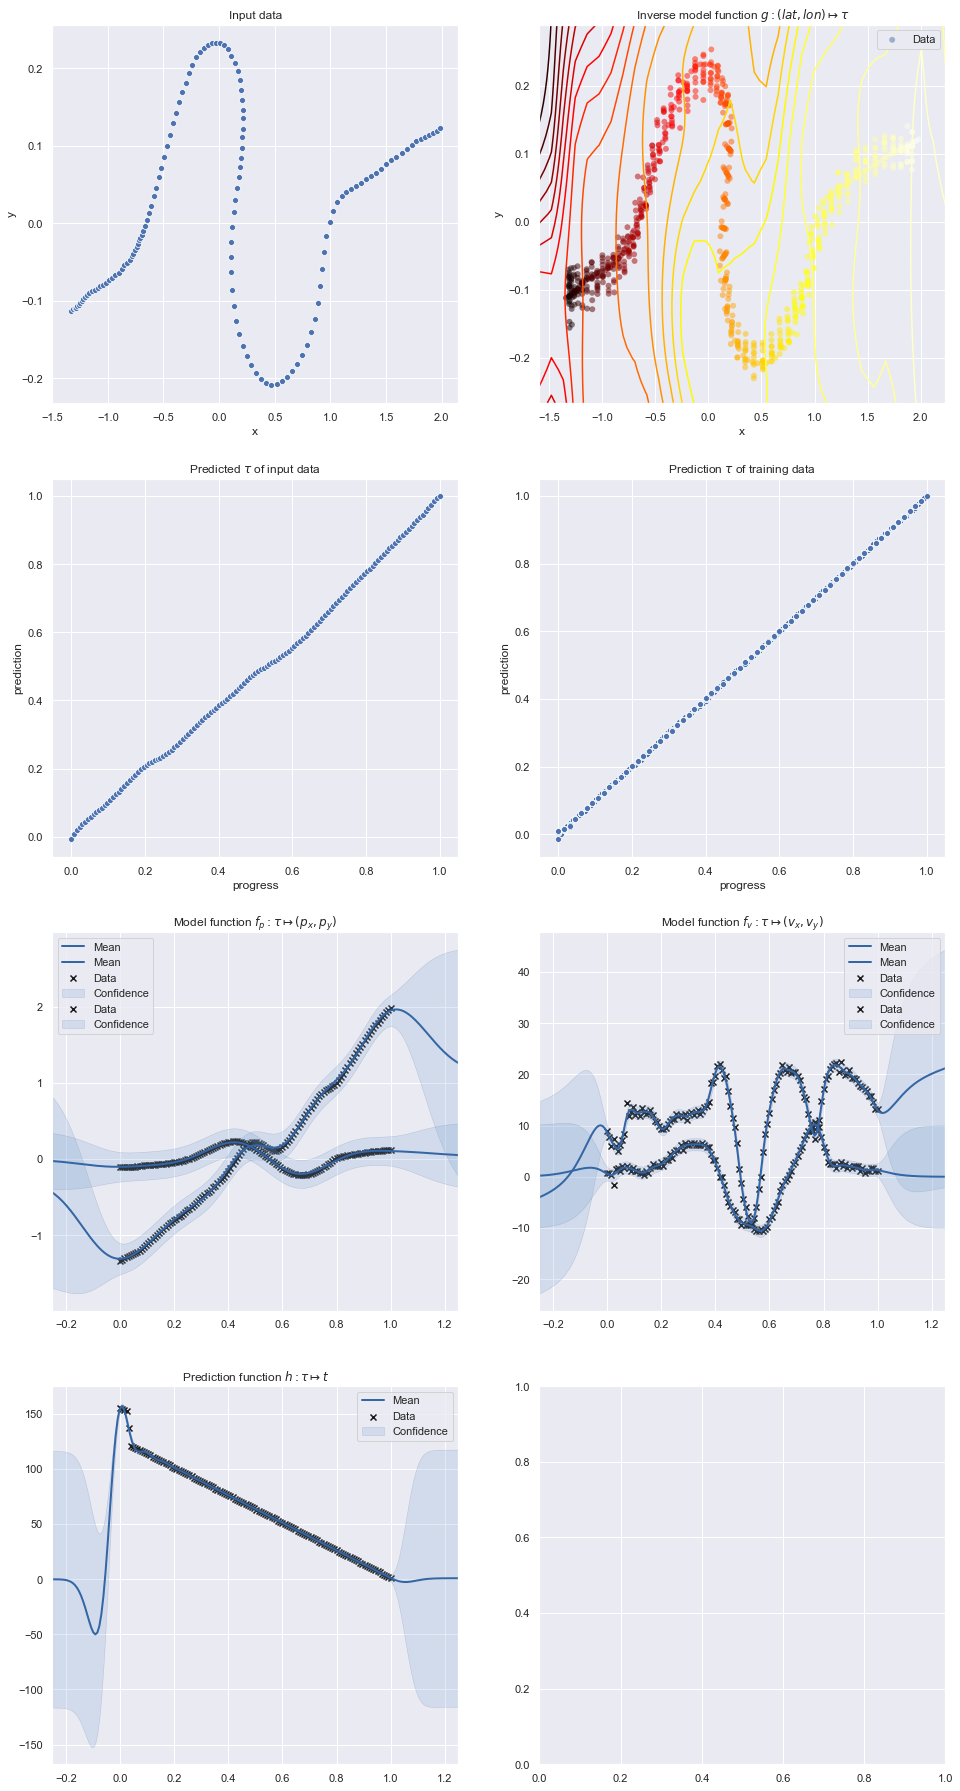

In [13]:
#plot_model(models[10])
#models[test_traj_ix].f_v.model #.plot(plot_limits=[0, fraction_observed])
plot_model(models[2], seg, 
    f_p_codomain, f_v_codomain)

# Make predictions

predicting for 875


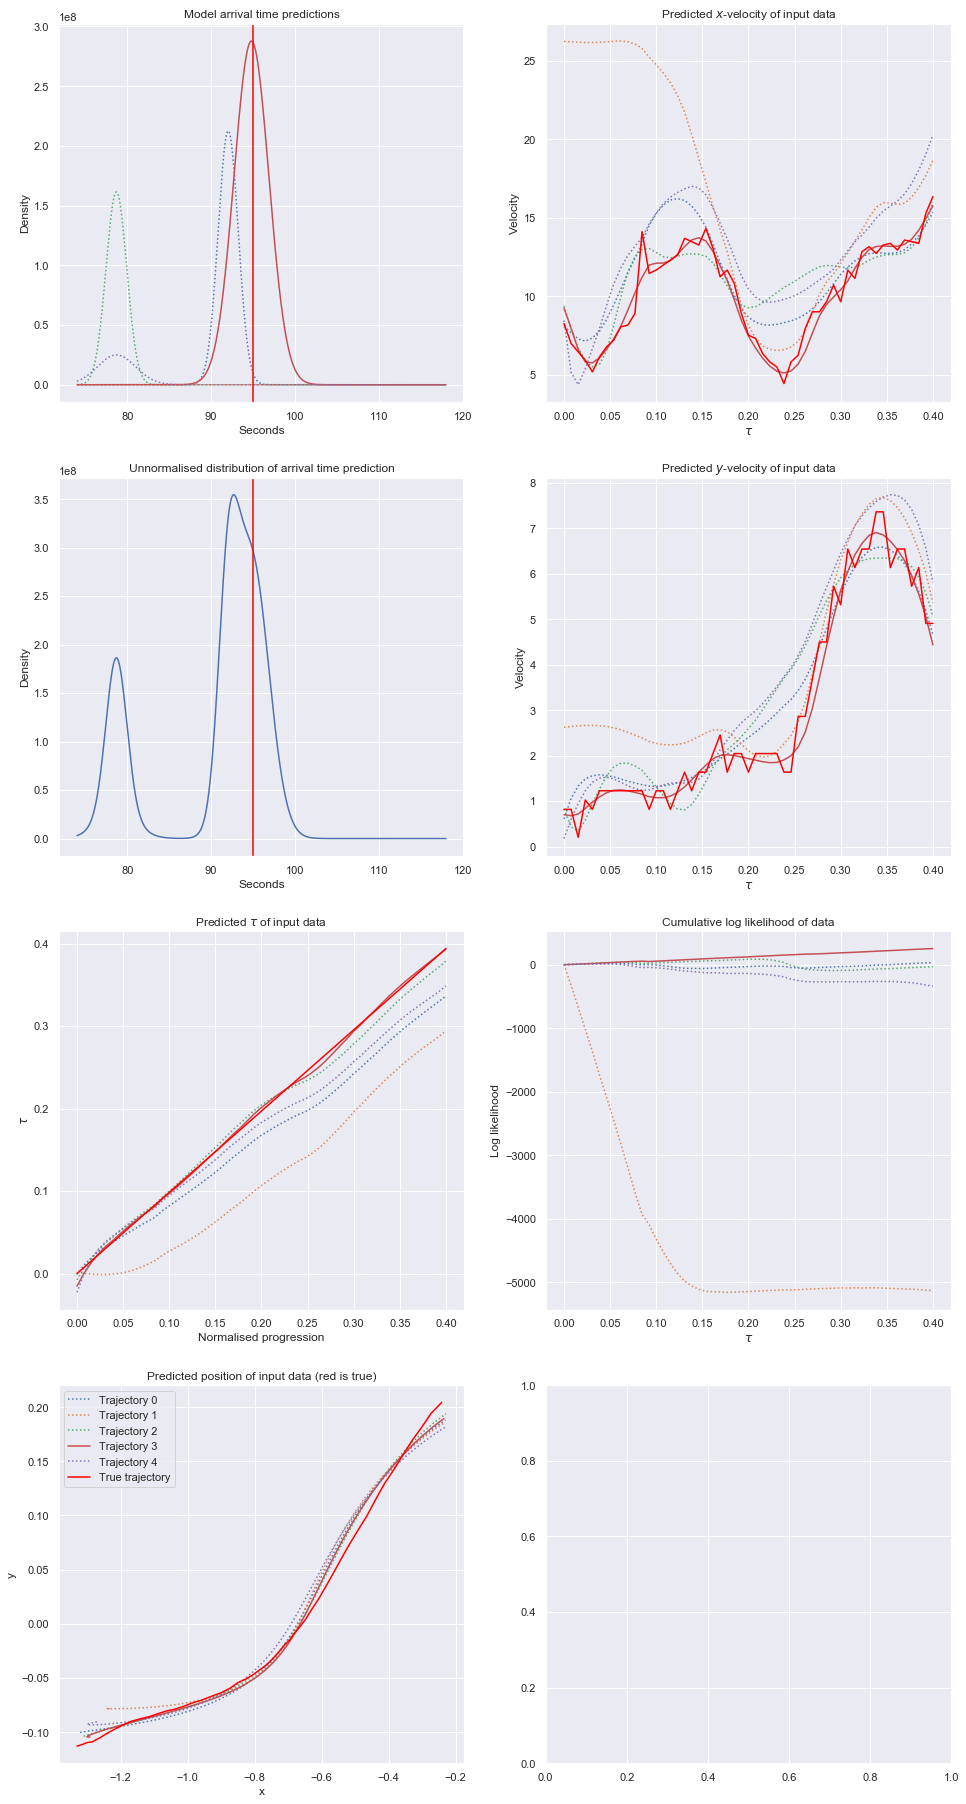

In [19]:
from functools import reduce
from scipy.stats import norm
from collections import defaultdict
from numpy.linalg import inv, det
import math
from plotting import plot_grid


def model_cum_loglik(model: TrajectoryModel, X_obs: ndarray):
    pos = X_obs[:,0:2]
    tau, _ = predict(model.g, pos)
    inc_tau, inc_X_obs = zip(*[
        (tau[:n], X_obs[:n]) 
        for n in range(len(tau))
    ])
    
    model_logliks = [
        model_loglik(model, tau, obs) 
        for tau, obs in zip(inc_tau, inc_X_obs)
    ]
    return np.array(model_logliks).reshape(len(model_logliks), -1)
    
def model_pred(model: TrajectoryModel, tau: ndarray):
    # predict for the last point
    last_point = tau[-1].reshape(1, 1)
    return predict(model.h, last_point)
    
def model_loglik(model: TrajectoryModel, tau: ndarray, X_obs: ndarray):
    """Returns the model prediction for the remaining arrival time
    together with the summed log likelihood of the data for the provided model.
    """
    def loglik(x: ndarray, mu: ndarray, sigma: ndarray):
        return -0.5*((x-mu).T).dot(inv(sigma)).dot((x-mu)) \
                -0.5*np.log(det(sigma))

    pos = X_obs[:,0:2]
    vel = X_obs[:,2:4]
    X_k_p_x, sigma_p_x = predict(model.f_p_x, tau)
    X_k_p_y, sigma_p_y = predict(model.f_p_y, tau)
    X_k_v_x, sigma_v_x = predict(model.f_v_x, tau)
    X_k_v_y, sigma_v_y = predict(model.f_v_y, tau)
    loglik_pos_x = loglik(pos[:,0].reshape(-1, 1), X_k_p_x, np.diag(sigma_p_x.T[0]))
    loglik_pos_y = loglik(pos[:,1].reshape(-1, 1), X_k_p_y, np.diag(sigma_p_y.T[0]))
    loglik_vel_x = loglik(vel[:,0].reshape(-1, 1), X_k_v_x, np.diag(sigma_v_x.T[0]))
    loglik_vel_y = loglik(vel[:,1].reshape(-1, 1), X_k_v_y, np.diag(sigma_v_y.T[0])) 
    loglik_sum = \
        loglik_pos_x + \
        loglik_pos_y + \
        loglik_vel_x + \
        loglik_vel_y
    
    if math.isinf(loglik_sum):
        print('inf loglik', loglik_pos_x, loglik_pos_y, loglik_vel_x, loglik_vel_y)

    return loglik_sum

def arrival_time_prediction(models, f_codomain, data):
        
    def make_mixture(
        grid_res: int,
        grid_pad: int,
        preds: ndarray,
        logliks: List[float]) -> ndarray:
    
        def make_distribution(
            xx: ndarray, 
            pred: ndarray, 
            loglik: List[float]) -> ndarray:
            mean = pred[0]
            var = pred[1]
            return loglik*norm.pdf(xx, mean, np.sqrt(var))
        
        # Create grid that covers all components
        asc_preds = sorted(preds)
        smallest_pred_mean = float(asc_preds[0][0])
        smallest_pred_var = float(asc_preds[0][1])
        xmin = max(0, np.floor(smallest_pred_mean - smallest_pred_var*grid_pad))
        biggest_pred_mean = float(asc_preds[-1][0])
        biggest_pred_var = float(asc_preds[-1][1])
        xmax = np.ceil(biggest_pred_mean + biggest_pred_var*grid_pad)
        xx = np.linspace(xmin, xmax, (xmax-xmin)*grid_res)
            
        distributions = [
            make_distribution(xx, p, l) 
            for p, l in zip(preds, logliks) 
        ]
        
        return distributions, xx
        
    X_obs = data[f_codomain].values
    pos = X_obs[:,0:2]
    taus, _ = zip(*[
        predict(m.g, pos)
        for m in models
    ])

    preds, logliks = zip(*[
        (model_pred(m, tau), model_loglik(m, tau, X_obs))
        for m, tau in zip(models, taus)
    ])

    # Scale to avoid numerical errors due to small numbers
    c = 1/max(logliks)
    loglik_sum = sum(logliks)
    norm_liks = [np.exp(c*l - c*loglik_sum) for l in logliks]
    grid_res = 100
    grid_pad = 3
    return make_mixture(
        grid_res, grid_pad, preds, norm_liks
    )


def plot_mixture(ax, xx, distributions, time_left):
    for i, dist in enumerate(distributions):
        linestyle = '-' if i == test_traj_ix else ':'
        ax.plot(
            xx, dist.reshape(xx.shape), 
            label='Trajectory ' + str(i),
            linestyle=linestyle
        )

    ax.set_title('Model arrival time predictions')
    ax.set_xlabel('Seconds')
    ax.set_ylabel('Density')
    ax.axvline(x=time_left, color='red', label='True arrival time')
    #ax.legend()

    
def plot_mixture_sum(ax, xx, distribution, time_left):
    ax.plot(xx, distribution)
    ax.set_title('Unnormalised distribution of arrival time prediction')
    ax.set_xlabel('Seconds')
    ax.set_ylabel('Density')
    ax.axvline(x=time_left, color='red', label='True arrival time')
    #ax.legend()
    
def plot_results(models, distributions, xx, seg, time_left, fraction_observed):
    n_rows = 4
    n_cols = 2
    _fig, axs = plot_grid(n_rows, n_cols)
    mixture_ax = axs[0][0]
    dist_sum_ax = axs[1][0]
    tau_pred_ax = axs[2][0]
    pos_pred_ax = axs[3][0]
    vel_x_pred_ax = axs[0][1]
    vel_y_pred_ax = axs[1][1]
    cum_tau_pred_ax = axs[2][1]
    
    plot_mixture(mixture_ax, xx, distributions, time_left)
    dist_sum = reduce(np.add, distributions).reshape(xx.shape[0])
    plot_mixture_sum(dist_sum_ax, xx, dist_sum, time_left)
    
    xx = np.linspace(0, fraction_observed, seg.shape[0])
    for i, m in enumerate(models):
        linestyle = '-' if i == test_traj_ix else ':'
        tau, _  = predict(m.g, seg[f_codomain].values)

        # Plot tau
        tau_pred_ax.plot(
            xx, tau.T[0], 
            label='Trajectory ' + str(i),
            linestyle=linestyle
        )

        # Plot position
        p_x, _ = predict(m.f_p_x, tau)
        p_y, _ = predict(m.f_p_y, tau)
        pos_pred_ax.plot(
            p_x, p_y, 
            label='Trajectory ' + str(i),
            linestyle=linestyle
        )
        
        # Plot velocity x
        v_x, _ = predict(m.f_v_x, tau)
        vel_x_pred_ax.plot(
            xx, v_x,
            label='Trajectory ' + str(i),
            linestyle=linestyle
        )

        # Plot velocity y
        v_y, _ = predict(m.f_v_y, tau)
        vel_y_pred_ax.plot(
            xx, v_y,
            label='Trajectory ' + str(i),
            linestyle=linestyle
        )

        # Plot cumulative log likelihood
        cum_tau_pred_ax.set_title(r'Cumulative log likelihood of data')
        cum_tau_pred_ax.set_xlabel(r'$\tau$')
        cum_tau_pred_ax.set_ylabel('Log likelihood')
        cum_tau_pred_ax.plot(
            xx, model_cum_logliks[i],
            label='Trajectory ' + str(i),
            linestyle=linestyle
        )
        
    tau_pred_ax.set_title(r'Predicted $\tau$ of input data')
    tau_pred_ax.set_xlabel('Normalised progression')
    tau_pred_ax.set_ylabel(r'$\tau$')
    tau_pred_ax.plot(
        xx, seg.tau,
        label='True trajectory',
        color='red'
    )
    #tau_pred_ax.legend()
    
    pos_pred_ax.set_title(r'Predicted position of input data (red is true)')
    pos_pred_ax.set_xlabel('x')
    pos_pred_ax.set_ylabel('y')
    pos_pred_ax.plot(
        seg.x, seg.y,
        label='True trajectory',
        color='red'
    )
    pos_pred_ax.legend()
    
    vel_x_pred_ax.set_title(r'Predicted $x$-velocity of input data')
    vel_x_pred_ax.set_xlabel(r'$\tau$')
    vel_x_pred_ax.set_ylabel('Velocity')
    vel_x_pred_ax.plot(
        xx, seg.dx,
        label='True trajectory',
        color='red'
    )
    #vel_x_pred_ax.legend()
    
    vel_y_pred_ax.set_title(r'Predicted $y$-velocity of input data')
    vel_y_pred_ax.set_xlabel(r'$\tau$')
    vel_y_pred_ax.set_ylabel('Velocity')
    vel_y_pred_ax.plot(
        xx, seg.dy,
        label='True trajectory',
        color='red'
    )
    #vel_y_pred_ax.legend()
    
    plt.show()

models_to_use = models
# Test on previously seen segment
test_traj_ix = 3
test_traj_id = traj_ns[test_traj_ix]
print('predicting for', test_traj_id)
fraction_observed = .4
seg = pre_process(
    load_seg(test_traj_id, seg_n), 
    stop_compress_delta, 
    fraction_observed
)

time_left = seg.iloc[-1].time_left
f_codomain = ['x', 'y', 'dx', 'dy']
distributions, xx = arrival_time_prediction(
    models_to_use, f_codomain, seg
)

X_obs = seg[f_codomain].values
model_cum_logliks = [
    model_cum_loglik(m, X_obs)
    for m in models_to_use
]


plot_results(
    models_to_use, distributions, xx, 
    seg, time_left, fraction_observed
)


# Performance

In [58]:
from IPython.display import display, clear_output
import math

seg_sizes = [.2, .4, .6, .8]
mape = {s: defaultdict(dict) for s in seg_sizes}
mae =  {s: defaultdict(dict) for s in seg_sizes}
#segs = dict(tuple(data[data.seg = seg_n].groupby('seg')))

#fig, ax = plot_grid(1, 1)
test_segs = {
    traj_n: pre_process(load_seg(traj_n, seg_n), stop_compress_delta)
    for traj_n in traj_ns
}
for test_seg_n in test_segs.keys():
    for seg_size in seg_sizes:
        test_seg = test_segs[test_seg_n]
        r = int(test_seg.shape[0]*seg_size)
        seg = test_seg.head(r)
        time_left = seg.iloc[-1].time_left
        dists, xx = arrival_time_prediction(
            models_to_use, f_codomain, seg
        )
        dist = reduce(np.add, dists).reshape(xx.shape[0])
        #pred = np.sum(dist * xx) / np.sum(dist) # mean
        pred = xx[np.argmax(dist)] #mode
        if math.isnan(pred):
            print('dists are nan for ', seg_size, test_seg_n)
            
        abs_diff = np.abs(time_left-pred)
        mae[seg_size][test_seg_n] = abs_diff
        mape[seg_size][test_seg_n] = abs_diff / time_left
        #plot_mixture_sum(ax, xx, dist, time_left)
        #pred_ix = reduce(lambda i, w: i*w, enumerate(dist)) / np.sum(dist)
        #print(pred_ix)
    #clear_output()
    print('Done seg', test_seg_n)
    
avg_mae = [np.sum(list(mae[s].values())) / len(mae[s].values()) for s in seg_sizes]
avg_mape = [np.sum(list(mape[s].values())) / len(mape[s].values()) for s in seg_sizes]

# loglik_pos_x, loglik_pos_y are inf

Done seg 147
Done seg 299
Done seg 392
Done seg 875
Done seg 1278
Done seg 1283
Done seg 1727
Done seg 1773
Done seg 2090
Done seg 2283
Done seg 2331
Done seg 2710
Done seg 2752
Done seg 2850
Done seg 2853
Done seg 2911
Done seg 2994
Done seg 3132
Done seg 3184
Done seg 3217


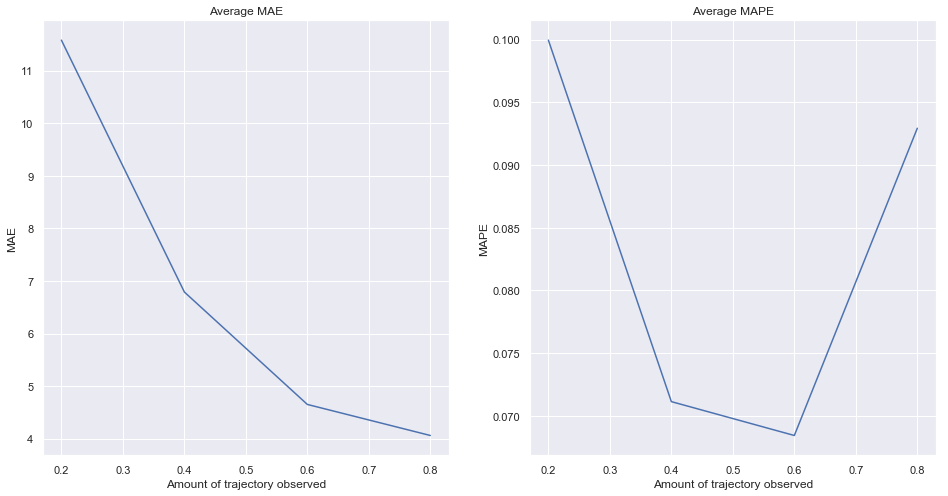

In [60]:
fig, ax = plot_grid(1, 2)
ax[0].plot(seg_sizes, avg_mae)
ax[0].set_title('Average MAE')
ax[0].set_ylabel('MAE')
ax[0].set_xlabel('Amount of trajectory observed')

ax[1].set_title('Average MAPE')
ax[1].set_ylabel('MAPE')
ax[1].set_xlabel('Amount of trajectory observed')
ax[1].plot(seg_sizes, avg_mape)